Import packages

In [1]:
using JuMP, HiGHS, Ipopt, Plots

Utility functions:

solve_evader_OCP - solve the optimal control problem where the evader avoids the pursuer with a cost x'*x and bounded turning rate

solve_pursuer_OCP - solve the optimal control problem where the pursuer tracks the evader with a cost x'*x and bounded turning rate

In [2]:
# function: solve_evader_OCP
# objective: given the state of an evader and state of a pursuer, find the optimal control for the evader to avoid the pursuer 
# inputs: 
#   - model: OCP solver model
#   - sim_params: struct of simulation parameters
#   - __pursuer: dubins car object for pursuer
#   - __evader: dubins car object for evader
function solve_evader_OCP(model, sim_params, __pursuer, __evader)


    N = sim_params.N
    Δt = sim_params.Δt


    x_pursuer = __pursuer.x_true[1]
    y_pursuer = __pursuer.x_true[2]

    x0 = __evader.x_measured[1]
    y0 = __evader.x_measured[2]
    θ0 = __evader.x_measured[3]

    v = __evader.v
    u_max = __evader.u_max

    # Decision variables
    @variable(model, x[1:N+1])      # x position
    @variable(model, y[1:N+1])      # y position
    @variable(model, θ[1:N+1])      # orientation
    @variable(model, ω[1:N])        # control input (turning rate)

    # Objective function (quadratic cost on position and control) --> maximize distance to pursuer
    @objective(model, Min, 
        -sum((x[k] - x_pursuer)^2 + (y[k] - y_pursuer)^2 for k in 1:N)) + sum(ω[k]^2 for k in 1:N)

    # Initial conditions
    @constraint(model, x[1] == x0)
    @constraint(model, y[1] == y0)
    @constraint(model, θ[1] == θ0)

    # Dubins car dynamics constraints
    for k in 1:N
        @constraint(model, x[k+1] == x[k] + v * cos(θ[k]) * Δt)
        @constraint(model, y[k+1] == y[k] + v * sin(θ[k]) * Δt)
        @constraint(model, θ[k+1] == θ[k] + ω[k] * Δt)

        # bounded control input
        @constraint(model, -u_max <= ω[k] <= u_max)

    end

    # Solve the optimization problem
    optimize!(model)

    # Extract results
    x_opt = value.(x)
    y_opt = value.(y)
    θ_opt = value.(θ)
    ω_opt = value.(ω)

    return x_opt,y_opt,θ_opt,ω_opt
end

# function: solve_pursuer_OCP
# objective: given the state of an evader and state of a pursuer, find the optimal control for the pursuer to catch the evader 
# inputs: 
#   - model: OCP solver model
#   - sim_params: struct of simulation parameters
#   - __pursuer: dubins car object for pursuer
#   - __evader: dubins car object for evader
function solve_pursuer_OCP(model, sim_params, __pursuer, __evader)
    N = sim_params.N
    Δt = sim_params.Δt

    x_evader = __evader.x_true[1]
    y_evader = __evader.x_true[2]
    θ_evader = __evader.x_true[3]

    x0 = __pursuer.x_true[1]
    y0 = __pursuer.x_true[2]
    θ0 = __pursuer.x_true[3]

    v = __pursuer.v
    u_max = __pursuer.u_max

    # Decision variables
    @variable(model, x[1:N+1])      # x position
    @variable(model, y[1:N+1])      # y position
    @variable(model, θ[1:N+1])      # orientation
    @variable(model, ω[1:N])        # control input (turning rate)

    # Objective function (quadratic cost on position and control)
    @objective(model, Min, 
        sum((x[k] - x_evader)^2 + (y[k] - y_evader)^2 for k in 1:N))

    # Initial conditions
    @constraint(model, x[1] == x0)
    @constraint(model, y[1] == y0)
    @constraint(model, θ[1] == θ0)

    # Dubins car dynamics constraints
    for k in 1:N
        @constraint(model, x[k+1] == x[k] + v * cos(θ[k]) * Δt)
        @constraint(model, y[k+1] == y[k] + v * sin(θ[k]) * Δt)
        @constraint(model, θ[k+1] == θ[k] + ω[k] * Δt)

        # bounded control input
        @constraint(model, -u_max <= ω[k] <= u_max)
    end
    
    # Solve the optimization problem
    optimize!(model)

    # Extract results
    x_opt = value.(x)
    y_opt = value.(y)
    θ_opt = value.(θ)
    ω_opt = value.(ω)

    return x_opt,y_opt,θ_opt,ω_opt
end

solve_pursuer_OCP (generic function with 1 method)

Define Dubins Car Dynamics

In [3]:
# Discrete-time Dubins Car Dynamics

@kwdef mutable struct Dubins_Car
    f::Function
    h::Function
    v::Float64
    x_true::Vector{Float64}
    x_measured::Vector{Float64}
    u_max::Float64
end

function f(x::Vector{Float64},u::Float64,w::Vector{Float64},v::Float64,δt::Float64)
    θ = x[3]
    xk = x + δt*[v*cos(θ) + w[1]; v*sin(θ) + w[2]; u]
    return xk
end

function h(x::Vector{Float64},v)
    return y = x[1:2]+v
end

h (generic function with 1 method)

In [4]:


@kwdef mutable struct Parameters
    N::Int64
    Δt::Float64
    T::Int64
end

# Parameters
T = 20                   # Total sim time [seconds]
Δt = 0.1                 # Time step
N = 0.2*(T/Δt)           # Time horizon

x0_pursuer = -1.5         # adversary x position
y0_pursuer = 0.0         # adversary y position
θ0_pursuer = pi/4        # adversary orientation
v_pursuer= 1.0           # Fixed pursuer forward velocity
up_max = 0.75             # Bound on input (turn rate)

x0_evader = 0.0          # Initial evader x position
y0_evader = 0.0          # Initial evader y position
θ0_evader = pi/2         # Initial evader orientation
v_evader = 0.50           # Fixed evader forward velocity
ue_max = 1.0             # Bound on input (turn rate)

pursuer_init_state = Vector{Float64}([x0_pursuer, y0_pursuer, θ0_pursuer])
evader_init_state = Vector{Float64}([x0_evader, y0_evader, θ0_evader])



sim_params = Parameters(N,Δt,T)

# pursuer and evader objects
__pursuer = Dubins_Car(f,h,v_pursuer,pursuer_init_state, pursuer_init_state, up_max)
__evader = Dubins_Car(f,h,v_evader,evader_init_state, evader_init_state,ue_max)

evader_model = Model(Ipopt.Optimizer)
pursuer_model = Model(Ipopt.Optimizer)


A JuMP Model
├ solver: Ipopt
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

Implement MPC finite-horizon simulation of pursuer/evader

In [5]:
K = Int64(sim_params.T / sim_params.Δt)
xₚ = fill(0.0f0, (3,K))
xₑ = fill(0.0f0, (3,K))

xₚ[:,1] = pursuer_init_state
xₑ[:,1] = evader_init_state


for t in 1:K-1

    ## Solve the optimal control problem for both pursuer and evader
    evader_model = Model(Ipopt.Optimizer)
    pursuer_model = Model(Ipopt.Optimizer)

    ## We let the evader play first

    # solve the evader OCP 
    _,_,_,ue_opt = solve_evader_OCP(evader_model, sim_params, __pursuer, __evader);

    # Extract the first optimal control value
    uₑ = ue_opt[1]

    # Update dubins car and store position
    xₑ_kplus1 = __evader.f(Vector{Float64}(xₑ[:,t]),uₑ,[0.0, 0.0],__evader.v,Δt)
    xₑ[:,t+1] = xₑ_kplus1
    __evader.x_true = xₑ_kplus1
    __evader.x_measured = xₑ_kplus1


    ## Now we let the disturbance play second
    _,_,_,up_opt = solve_pursuer_OCP(pursuer_model, sim_params, __pursuer, __evader);

    # extract first optimal control value
    uₚ = up_opt[1]

    # Update dubins car and store position
    xₚ_kplus1  = __pursuer.f(Vector{Float64}(xₚ[:,t]),uₚ,[0.0, 0.0],__pursuer.v,Δt)
    xₚ[:,t+1] = xₚ_kplus1
    __pursuer.x_true = xₚ_kplus1
    __pursuer.x_measured = xₚ_kplus1


    println(t)
end





******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      363
Number of nonzeros in inequality constraint Jacobian.:       40
Number of nonzeros in Lagrangian Hessian.............:      160

Total number of variables............................:      163
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      123
Total number of inequality c

Excessive output truncated after 527983 bytes.

Plot/Animate results

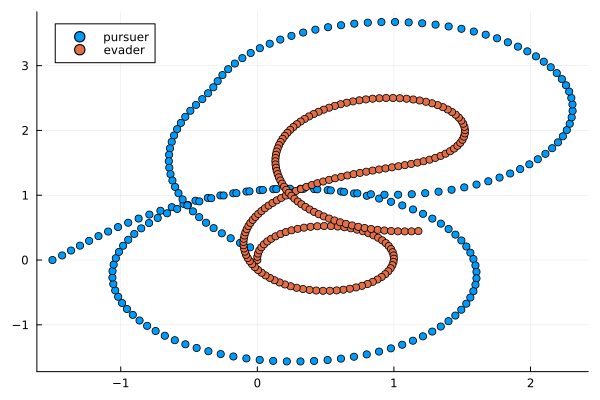

In [6]:
plot(xₚ[1,:],xₚ[2,:],seriestype=:scatter,label="pursuer")
plot!(xₑ[1,:],xₑ[2,:],seriestype=:scatter,label="evader")

Plots.AnimatedGif("c:\\Users\\remba\\UCSD\\SAS Lab\\State-Selection-Algorithm\\pursuit_evasion.gif")
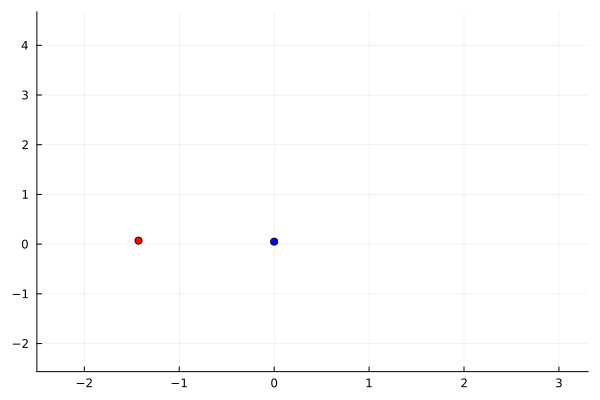

In [7]:
xmin = minimum(vcat(xₚ[1,:], xₑ[1,:]))
ymin = minimum(vcat(xₚ[2,:], xₑ[2,:]))

xmax = maximum(vcat(xₚ[1,:], xₑ[1,:]))
ymax = maximum(vcat(xₚ[2,:], xₑ[2,:]))


function animate_frame(i)
    plot((xₚ[1,i],xₚ[2,i]),seriestype=:scatter, label = false, mc=:red)
    plot!((xₑ[1,i],xₑ[2,i]),seriestype=:scatter, label = false,mc=:blue)
    xlims!(xmin-1,xmax+1)
    ylims!(ymin-1,ymax+1)
end

plot((xₚ[1,1],xₚ[2,1]),seriestype=:scatter, label = false, mc=:red)
plot!((xₑ[1,1],xₑ[2,1]),seriestype=:scatter, label = false,mc=:blue)

anim = @animate for i in 2:K-1
    animate_frame(i)
end
gif(anim, "pursuit_evasion.gif",fps=100)


Now we introduce some uncertainty. Let's say that we do not know the true state of the evader, but we know the true state of the pursuer and the pursuer knows the true state of the evader.

Since we do not know the true state of the evader, we can estimate the state of the evader using a bootstrap particle filter

Let's first define our boostrap particle filter

In [8]:
## Bootstrap Partilce Filter (additive Gaussian)

Base.@kwdef mutable struct Particle_Filter
    model::Dubins_Car
    TimeUpdate::Function
    MeasurementUpdate::Function
    Resampler::Function
    likelihoods::Vector
    particles::Array
end

## function: TimeUpdate
# input: 
#       - x: set of particles in [n x L] matrix
#       - model: set of dynamics
#       - u: input
#       - w: randomly generated noise of same size as x, [n x L]
#       - Δt: time step
# output:
#       - x_plus: all particles propagated one time step
function TimeUpdate(x, model, u, w, Δt)
    x_plus = Array{Float64}(undef, size(x))
    for i = axes(x_plus,2)
        x_plus[:,i] = model.f(x[:,i],u,w[:,i], __evader.v, Δt)
    end
    return x_plus
end

## function: MeasurementUpdate
# input: 
#       - particle_filter: particle filter struct
#       - model: set of dynamics
#       - y: observation taken of true state
#       - var: measurement variance
#
# objective: calculate the likelihood associated with each particle in the density
function MeasurementUpdate!(particle_filter, model, y, var)
    x = particle_filter.particles
    likelihoods = Vector(fill(0.0,(L)))
    R = I(2)*var
    for i = axes(x,2)
        err = y-model.h(x[:,i],[0.0, 0.0])
        likelihoods[i] = exp.((-1/2)* err' * inv(R) *err)
    end
    particle_filter.likelihoods = particle_filter.likelihoods.*likelihoods./(sum(particle_filter.likelihoods.*likelihoods))
end


## function: Resampler
# input:
#   - particle_filter: particle filter objective
# objective: given updated particle likelihoods, resample from current particles to avoid depletion
function Resampler(particle_filter)
    x_resampled = fill(NaN, size(particle_filter.particles))
    CDF = cumsum(particle_filter.likelihoods)
    for i = axes(x_resampled,2)
        x_resampled[:,i] = particle_filter.particles[:,findfirst(CDF .>= rand(1))]
    end
    particle_filter.particles = x_resampled
    particle_filter.likelihoods = Vector(fill(1,(L)))
end

## functionL propagate_bootstrap_pf
# input: 
#       - pf: particle filter struct
#       - dubins_car: dynamics of a discrete time dubins car
#       - u: input signal
#       - Σ: process noise variance
#       - R: measurement noise variance
#       - L: number of particles in the density
#       - y: measurement of true state to be used in boostrap pf
# 
# objective:
#       - propagate the particle density one time step based on the observation of the state
function propagate_bootstrap_pf(pf::Particle_Filter, dubins_car::Dubins_Car, u::Float64, Σ, R, L, y)
    # randomly generated process noise
    w = randn((2,L))*sqrt(Σ)

    # propagate all particles through one time step of dynamics
    pf.particles = pf.TimeUpdate(pf.particles, dubins_car, u, w, Δt)

    # calculate measurement likelihoods
    pf.MeasurementUpdate(pf, dubins_car, y, R)

    # resample particles to avoid depletion
    pf.Resampler(pf)
end

propagate_bootstrap_pf (generic function with 1 method)

Setup for simple test case of particle filter applied to Dubins Car

In [9]:
using CUDA, LinearAlgebra, Distributions

####
# function: gpu_generate_Xi
# input: 
#   - L = number of particles
#   - n = number of dimensions of the state
#   - μ = mean state  
#   - var = covariance
# output: Ξ₀ = Array of randomly sampled states, size: [2 x L]
###
function gpu_generate_Xi(L :: Int64, n :: Int64, μ::Vector{Float64}, var)
    # Gaussian Density with mean vector μ_x0 and covariance matrix Σ_x0
    μ_x0 = CuArray(μ)
    Σ_x0 = (var*I)

    # randomly sample initial states Ξ following Gaussian density
    Ξ₀ = CuArray{Float64}(undef,n,L)
    Ξ₀ = μ_x0.+sqrt(Σ_x0)*CUDA.randn(n,L)
    return (Ξ₀)
end


## function: test_pf
#  inputs: 
#       - pf: particle filter object
#       - __evader: evading dubins car object
# objective: run particle filter with a dubins car model with additive gaussian noise and constant turning rate as input
function test_pf(pf::Particle_Filter, __evader::Dubins_Car, K, Xi_init)

    w_true = randn((2,K))*sqrt(Σ)
    test_data = Array{Float64}(undef, (3, L, K))
    Xi_plus = Array{Float64}(undef, (3,L))

    u = -0.2

    Ξ = Xi_init

    for t = 1:K-1
        test_data[:,:,t] = pf.particles
        # propagate the true particle one time step forward 
        xtrue_plus = __evader.f(x_true[:,t], u, w_true[:,t], __evader.v, Δt)
        x_true[:,t+1] = xtrue_plus
        __evader.x_true = xtrue_plus

        # take measurement of this updated true state
        y = __evader.h(xtrue_plus, sqrt(R)*randn(2))

        # based on new observation, update particles with bootstrap particle filter
        propagate_bootstrap_pf(pf, __evader, u, Σ, R, L, y)

    end

    return test_data
end

test_pf (generic function with 1 method)

Run test case

In [10]:

L = 500                         # number of particles               
n = 3                           # dimension of states
μ = [evader_init_state[1],      # mean initial state
    evader_init_state[2]]
R = 0.75                         # measurement variance
Σ = 0.10                      # process variance

# initial state density
Ξ = vcat(Array(gpu_generate_Xi(L, n-1, μ, R)), fill(evader_init_state[3],(L))')

# initialize particle filter with the initial state density
pf = Particle_Filter(__evader, TimeUpdate, MeasurementUpdate!, Resampler, Vector(fill(1,(L))) , Ξ)
pf.particles = Ξ
# inital candidate state is the conditional mean
x_star = vec(mean(pf.particles, dims=2))

# randomly generate a true state
x_true = Matrix{Float64}(undef, (n,K))
x_true[:,1] = vcat((μ + sqrt(Σ)*randn(2)), evader_init_state[3])
__evader.x_true = x_true[:,1]
__evader.x_measured = x_star

# perform a simple simulation with the particle filter
test_data = test_pf(pf, __evader, K, Ξ);


Plot results

In [11]:
plot(Ξ[1,:], Ξ[2,:], seriestype=:scatter, ms = 0.5, label = false)
for i = 2:K-1
    plot!(test_data[1,:,i], test_data[2,:,i], seriestype=:scatter, ms = 0.5, label=false)
end
plot!(x_true[1,:], x_true[2,:], seriestype=:scatter, ms = 4.0, label = "x_true")
savefig("test.png")

"c:\\Users\\remba\\UCSD\\SAS Lab\\State-Selection-Algorithm\\test.png"

Now, let's apply the particle filter to the pursuit/evasion MPC loop

In [12]:

function MPC_loop(sim_params, __evader, __pursuer)
    K = Int64(sim_params.T / sim_params.Δt)
    xₚ = fill(0.0f0, (3,K))
    xₑ = fill(0.0f0, (3,K))

    xₚ[:,1] = pursuer_init_state
    xₑ[:,1] = evader_init_state

    w_true = randn((2,K))*sqrt(Σ)
    test_data = Array{Float64}(undef, (3, L, K))

    # intial state density
    Ξ = vcat(Array(gpu_generate_Xi(L, n-1, μ, R)), fill(evader_init_state[3],(L))')

    # initialize particle filter with the initial state density
    pf = Particle_Filter(__evader, TimeUpdate, MeasurementUpdate!, Resampler, Vector(fill(1,(L))) , Ξ)
    pf.particles = Ξ
    # inital candidate state is the conditional mean
    x_star = vec(mean(pf.particles, dims=2))
    __evader.x_measured = x_star


    for t in 1:K-1

        ## Solve the optimal control problem for both pursuer and evader
        filtered_evader_model = Model(Ipopt.Optimizer)
        filtered_pursuer_model = Model(Ipopt.Optimizer)

        test_data[:,:,t] = pf.particles 

        ## We let the evader play first

        # solve the evader OCP 
        _,_,_,ue_opt = solve_evader_OCP(filtered_evader_model, sim_params, __pursuer, __evader);

        # Extract the first optimal control value
        uₑ = ue_opt[1]

        # Update dubins car and store position
        xₑ_kplus1 = __evader.f(Vector{Float64}(xₑ[:,t]),uₑ,w_true[:,t],__evader.v,Δt)
        xₑ[:,t+1] = xₑ_kplus1
        __evader.x_true = xₑ_kplus1


        # take measurement of this updated true state
        y = __evader.h(__evader.x_true, sqrt(R)*randn(2))

        # based on new observation, update particles with bootstrap particle filter
        propagate_bootstrap_pf(pf, __evader, uₑ, Σ, R, L, y)
        
        # evader will act on the conditional mean of the probability distribution
        __evader.x_measured = vec(mean(pf.particles, dims=2))


        ## Now we let the disturbance play second
        _,_,_,up_opt = solve_pursuer_OCP(filtered_pursuer_model, sim_params, __pursuer, __evader);

        # extract first optimal control value
        uₚ = up_opt[1]

        # Update dubins car and store position
        xₚ_kplus1  = __pursuer.f(Vector{Float64}(xₚ[:,t]),uₚ,[0.0, 0.0],__pursuer.v,Δt)
        xₚ[:,t+1] = xₚ_kplus1
        __pursuer.x_true = xₚ_kplus1
        __pursuer.x_measured = xₚ_kplus1


        println(t)
    end

    return xₑ, xₚ, test_data

end

xₑ, xₚ, test_data = MPC_loop(sim_params, __evader, __pursuer)

(Float32[0.0 0.01633358 … 2.1268673 2.1731868; 0.0 0.010501685 … 2.4265008 2.5188339; 1.5707964 1.4707963 … 0.9104003 0.948719], Float32[-1.5 -1.4292893 … 1.2158265 1.3103328; 0.0 0.07071068 … 1.0422813 1.0749702; 0.7853982 0.7103982 … 0.33301044 0.40801042], [-0.6408411016957066 0.8778846939323308 … 0.16080664421337734 -0.7912846622439237; 0.2931082720743971 0.4391808789962047 … -0.27710226182930786 -0.05275778373521525; 1.5707963267948966 1.5707963267948966 … 1.5707963267948966 1.5707963267948966;;; -0.8923209524882936 -0.011943938191952157 … 0.24273081188868578 -1.9811365125524656; 0.5098698817177271 -0.40540967087741175 … 0.10469157139603327 2.2769244800184123; 1.470796325976127 1.470796325976127 … 1.470796325976127 1.470796325976127;;; 0.9052717085146008 -0.30287122428198604 … 0.23011038346820717 1.0978285940319121; 0.588702215143522 0.20363853811754973 … 1.0468936570561265 0.35525335127153124; 1.3707963250638893 1.3707963250638893 … 1.3707963250638893 1.3707963250638893;;; … ;;; 

Plots.AnimatedGif("c:\\Users\\remba\\UCSD\\SAS Lab\\State-Selection-Algorithm\\filtered_pursuit.gif")
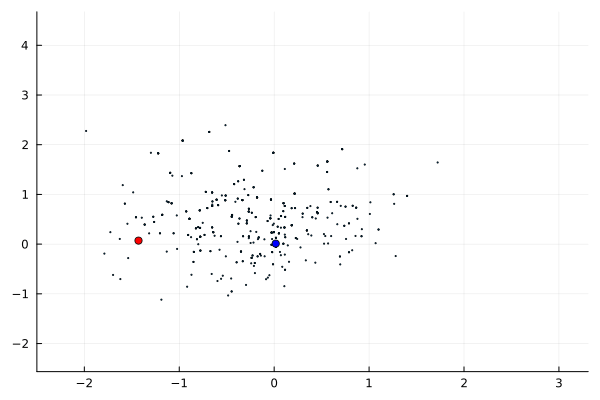

In [13]:
function animate_frame(i)
    plot(test_data[1,:,i], test_data[2,:,i], seriestype=:scatter, ms = 0.75, label=false)
    plot!((xₑ[1,i],xₑ[2,i]),seriestype=:scatter, label = false,mc=:blue)
    plot!((xₚ[1,i],xₚ[2,i]),seriestype=:scatter, label = false,mc=:red)
    xlims!(xmin-1,xmax+1)
    ylims!(ymin-1,ymax+1)
end


plot((xₚ[1,1], xₚ[2,1]), seriestype=:scatter, label = "true pursuer",mc=:red)
anim = @animate for i = 2:K-1
    animate_frame(i)
end
gif(anim, "filtered_pursuit.gif",fps=100)



Now, let's implement the State Selection Algorithm for comparison. 

First implement SSA on a single time step

In [14]:
# import Packages
using CUDA
using Test
using BenchmarkTools
using Random
using LinearAlgebra
using Distributions

In [15]:
@kwdef mutable struct SSA_Params
    M :: Int64
    N :: Int64
    L :: Int64
    n :: Int64
    T :: Int64
    α :: Float32
    ϵ :: Float32
    δ :: Float64
end

SSA_Params

In [16]:
L = 500                  # total number of particles
M = 100                  # Monte Carlo Samples
N = 0.2*(T/Δt)           # Time horizon
n = 3                    # dimension of state
α = 0.15
ϵ = 0.30
δ = 0.10
ssa_params =  SSA_Params(M,N,L,n,T,α,ϵ,δ)

# initial state density
Ξ = vcat(Array(gpu_generate_Xi(L, n-1, μ, R)), fill(evader_init_state[3],(L))')



3×500 Matrix{Float64}:
 -0.0359963  -0.491051   0.0748999  …  0.247227   0.174967  0.369822
 -0.705961    0.0109063  0.330528      0.553378  -0.413408  1.94448
  1.5708      1.5708     1.5708        1.5708     1.5708    1.5708